# Wrapping Libraries - BAGEL Example

In this notebook we look at how users can add support for their own simulation packages by adding simple wrappers. The example covered in this notebook is the [BAGEL Microlensing package](https://github.com/MovingUniverseLab/bagle_microlensing). To run this notebook you will need to install BAGEL. See the instructions [here](https://bagle.readthedocs.io/en/latest/installation.html).

This notebook is based on the [lightcurvelynx_BAGLE.ipynb notebook](https://github.com/LSST-TVSSC/microlensing/blob/main/lightcurvelynx_simulations/lightcurvelynx_BAGLE.ipynb) by Natasha Abrams and Katarzyna Kruszynska (2025).


## BAGEL

[Bagel](https://github.com/MovingUniverseLab/bagle_microlensing) is a package for simulating and analyzing gravitational lensing effects, which includes functions to model the output of such event. For an introduction to BAGEL, see their tutorial notebook: [https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb](https://github.com/MovingUniverseLab/BAGLE_Microlensing/blob/main/BAGLE_TUTORIAL.ipynb).

The core concept that we want to wrap in this example is the BAGEL model, which is a class that represents a microlensing event. The object's constructor takes in the parameters as (order dependent) arguments. For example, we can create a `PSPL_PhotAstrom_noPar_Param1` (point source, point lens) object as:

In [1]:
from bagle import model

# Create the event model with given parameter.
event1 = model.PSPL_PhotAstrom_noPar_Param1(
    1.0,  # mL (msun)
    61800,  # t0 (MJD)
    0.1,  # beta (mas)
    4000.0,  # dL (pc)
    4000.0 / 8000.0,  # dL/dS
    0.0,  # xS0_E (mas/yr)
    0.0,  # xS0_N (mas/yr)
    5.0,  # muL_E (mas/yr)
    10.0,  # muL_N (mas/yr)
    0.0,  # muS_E (mas/yr)
    0.0,  # muS_N (mas/yr)
    [1, 1, 1, 1, 1, 1],  # b_sff
    [23, 22, 21.5, 21, 20.5, 19.5],  # mag_src
)

Given the model, we can query for terms such as the amplification level over given times. Here we use 200.0 days before the given t0 to 200.0 days after it.

Text(0, 0.5, 'Amplification')

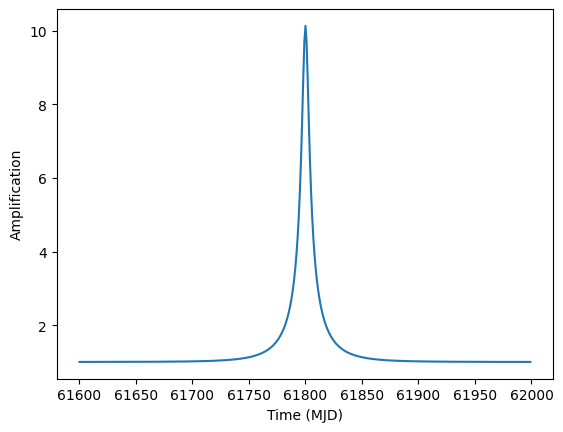

In [2]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(61600.0, 62000.0, 1.0)

A = event1.get_amplification(t)
plt.plot(t, A)
plt.xlabel("Time (MJD)")
plt.ylabel("Amplification")

## Wrapping BAGEL Models

To wrap a BAGEL model we need to design a subclass of LightCurveLynx's `BasePhysicalModel` that: 1) constructs the BAGEL model, 2) sets its parameters, and 3) queries the flux that it produces. Since BAGEL models operate on the bandflux level, we start by subclassing LightCuvreLynx's `BandfluxModel` class.

We start using tan alternative approach for creating a model from the model name (given in Abrams and Kruszynska's notebook):

In [3]:
# Hard-coded coordinates of the event
raL, decL = 270.66679, -35.70483
muL, muS = [5, 10], [0, 0]

model_name = "PSPL_PhotAstrom_Par_Param1"

mL = 1  # Msun (Primary lens current mass)
t0 = 61800  # mjd
xS0 = np.array([0, 0])  # arbitrary offset (arcsec)
beta = 0.1
dL = 4000  # Distance to lens
dS = 8000  # Distance to source
mag_src = [23, 22, 21.5, 21, 20.5, 19.5]
b_sff = [1, 1, 1, 1, 1, 1]

parameter_dict = {
    "raL": raL,
    "decL": decL,
    "mL": mL,
    "t0": t0,
    "beta": beta,
    "dL": dL,
    "dL_dS": dL / dS,
    "xS0_E": xS0[0],
    "xS0_N": xS0[1],
    "muL_E": muL[0],
    "muL_N": muL[1],
    "muS_E": muS[0],
    "muS_N": muS[1],
    "b_sff": b_sff,
    "mag_src": mag_src,
}

# Create the model object, by creating the model class by name and passing the parameters as a dictionary.
# NOTE: the parameters must be passed in the correct order, as expected by the model class.
mod_class = getattr(model, model_name)
mod = mod_class(**parameter_dict)

In [4]:
from lightcurvelynx.models.periodic_model import BandfluxModel


class BagelModel(BandfluxModel):
    def __init__(self, model_name, parameter_dict):
        self.model_name = model_name
        self.parameter_dict = parameter_dict
        mod_class = getattr(model, model_name)
        self.model_obj = mod_class(**parameter_dict)

    def get_flux(self, t):
        A = self.model_obj.get_amplification(t)
        return A

ImportError: cannot import name 'BandfluxModel' from 'lightcurvelynx.models.periodic_model' (/Users/jkubica/h/lightcurvelynx/src/lightcurvelynx/models/periodic_model.py)

Load the passband information, using the same filters. For most models the passband information will be used to convert the SED into bandfluxes. However, since we already have light curves at the bandflux level, we will just generate observations directly from those.